In [1]:
import pymatbridge
ip = get_ipython()
pymatbridge.load_ipython_extension(ip)

Starting MATLAB on ZMQ socket tcp://127.0.0.1:49472
Send 'exit' command to kill the server
..............MATLAB started and connected!


# A demo of Computer final project

This demo illustrates how to solve convection-diffusion equation using a finite difference formulation. 
In particular, it illustrates how to:

1. Create mesh
2. Assemble linear system $Ax=b$ and apply boundary conditions
3. Solve linear system
4. Plot solutiong

Let's start!

<bf><font color='red'>Note:</font> In following code cell, omit the command <font color='blue'>%%matlab</font>.

## Problem 

Consider the following one-dimensional convection-diffusion problem

$$\begin{split}
    & -\varepsilon u''(x) + u'(x) = 1,\quad\mbox{for }x\in(0,1) \\
    & u(0) = 0,\quad u(1) = 0
\end{split}
$$

## Implement

This description goes through the implementation (complete code in <font color='blue'>demo_cdm_conv_diff.m</font> ) of a solver for the above described convection-diffusion problem step-by-step.

To implemet the finite difference method, we must define some parameters first.

In [2]:
%%matlab

epsilon = 0.01;

% Exact solution
ue = @(x) (x - exp((x-1)/epsilon) - x .* exp(-1 / epsilon) + exp(-1 / epsilon)) / (1 - exp(-1/epsilon));

% Define boundary condition
u0 = 0;
u1 = 0;

### Create mesh

Then, we need to create a mesh covering the unit interval. In this example, we will let the mesh size is $h=1/5$.

In [3]:
%%matlab

n = 5;
h = 1 / n;
m = n - 1;
x = linspace(0, 1, n + 1)


x =

         0    0.2000    0.4000    0.6000    0.8000    1.0000



### Finite difference method

Next, we need to discrete numerical approximations to the derivative.

Replace $\displaystyle u''(x_i)\approx\frac{U_{i+1} - 2U_i + U_{i-1}}{h^2}$ and $\displaystyle u'(x_i)\approx\frac{U_{i+1} - U_{i-1}}{2h}$. 

For $i = 1, 2, ..., m$, we have

$$
\begin{split}
    &-\varepsilon\frac{U_{i+1} - 2U_i + U_{i-1}}{h^2}+\frac{U_{i+1} - U_{i-1}}{2h} = 1, \\
    \Longrightarrow &\left(-\frac{\varepsilon}{h^2} - \frac{1}{2h}\right)U_{i-1} + \left(-\frac{2\varepsilon}{h^2}\right)U_i
    +\left(-\frac{\varepsilon}{h^2} + \frac{1}{2h}\right)U_{i+1} = 1
\end{split}
$$

We wish to find $U_i$ for $i = 1,2,..., m$ and $U_0 = U_{m+1} = 0$ such that (for example $m=4$)

$$
\begin{split}
&\left(-\frac{\varepsilon}{h^2} - \frac{1}{2h}\right)U_0 + \left(-\frac{2\varepsilon}{h^2}\right)U_1 + \left(-\frac{\varepsilon}{h^2} + \frac{1}{2h}\right)U_2 = 1,\qquad (i=1)\\
&\left(-\frac{\varepsilon}{h^2} - \frac{1}{2h}\right)U_1 + \left(-\frac{2\varepsilon}{h^2}\right)U_2 + \left(-\frac{\varepsilon}{h^2} + \frac{1}{2h}\right)U_3 = 1,\qquad (i=2) \\
&\left(-\frac{\varepsilon}{h^2} - \frac{1}{2h}\right)U_2 + \left(-\frac{2\varepsilon}{h^2}\right)U_3 + \left(-\frac{\varepsilon}{h^2} + \frac{1}{2h}\right)U_4 = 1,\qquad (i=3) \\
&\left(-\frac{\varepsilon}{h^2} - \frac{1}{2h}\right)U_3 + \left(-\frac{2\varepsilon}{h^2}\right)U_4 + \left(-\frac{\varepsilon}{h^2} + \frac{1}{2h}\right)U_5 = 1,\qquad (i=4) \\
\end{split}
$$

Finally, we reach at the following linear system

$$
\begin{bmatrix}
-\frac{2\varepsilon}{h^2} & -\frac{\varepsilon}{h^2} + \frac{1}{2h} & 0 & 0  \\
-\frac{\varepsilon}{h^2} - \frac{1}{2h} & -\frac{2\varepsilon}{h^2} & -\frac{\varepsilon}{h^2} + \frac{1}{2h} & 0  \\
0 & -\frac{\varepsilon}{h^2} - \frac{1}{2h} & -\frac{2\varepsilon}{h^2} & -\frac{\varepsilon}{h^2} + \frac{1}{2h}  \\
0 & 0 & -\frac{\varepsilon}{h^2} - \frac{1}{2h} & -\frac{2\varepsilon}{h^2} \\
\end{bmatrix}
\begin{bmatrix}
U_1 \\ U_2 \\ U_3 \\ U_4
\end{bmatrix}=
\begin{bmatrix}
1 - (-\frac{\varepsilon}{h^2} - \frac{1}{2h})U_0 \\ 1 \\ 1 \\ 1 - (-\frac{\varepsilon}{h^2} + \frac{1}{2h})U_5
\end{bmatrix}
$$

### Assemble $Ax = b$ of linear system and apply boundary conditions

In [4]:
%%matlab

left_coef = -epsilon / (h * h) - 1 / (2 * h);
right_coef = -epsilon / (h * h) + 1 / (2 * h);
center_coef = (2 * epsilon) / (h * h);

A = zeros(m, m);
for i = 1:m
    for j = 1:m
        
        if (i == j)
            A(i, j) = center_coef;
        end
    
        if (j == i - 1)
            A(i, j) = left_coef;
        end
    
        if (j == i + 1)
            A(i, j) = right_coef;
        end
    end
end
A

b = zeros(m, 1);
for i = 1:m
    
    b(i) = 1;
    
    if (i == 1)
        b(i) = b(i) - left_coef * u0;
    end
    
    if (i == m)
        b(m) = b(m) - right_coef * u1;
    end
end
b


A =

    0.5000    2.2500         0         0
   -2.7500    0.5000    2.2500         0
         0   -2.7500    0.5000    2.2500
         0         0   -2.7500    0.5000


b =

     1
     1
     1
     1



## Solving linear systems $Ax=b$


In [5]:
%%matlab

cdm_sol = A\b;
cdm_sol = [u0; cdm_sol; u1]


cdm_sol =

         0
   -0.3962
    0.5325
   -0.1581
    1.1304
         0



## Plot solution

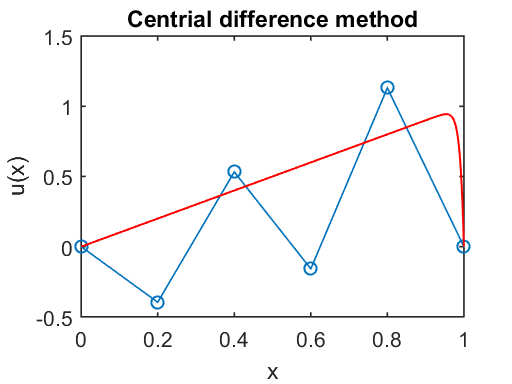

In [6]:
%%matlab

xe = linspace(0, 1, 501);
plot(x, cdm_sol, '-o',xe, ue(xe), 'r')
title('Centrial difference method')
xlabel('x')
ylabel('u(x)')

## Complete code

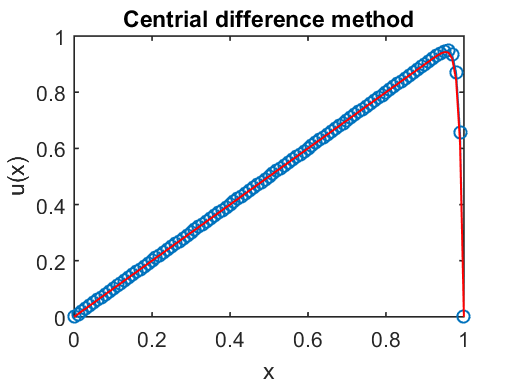

In [7]:
%%matlab

epsilon = 0.01;
ue = @(x) (x - exp((x-1)/epsilon) - x .* exp(-1 / epsilon) + exp(-1 / epsilon)) / (1 - exp(-1/epsilon));

% Define boundary condition
u0 = 0;
u1 = 0;

% Crate mesh
n = 100;
h = 1 / n;
m = n - 1;
x = linspace(0, 1, n + 1);

% Assemble linear system

left_coef = -epsilon / (h * h) - 1 / (2 * h);
right_coef = -epsilon / (h * h) + 1 / (2 * h);
center_coef = (2 * epsilon) / (h * h);

A = zeros(m, m);
for i = 1:m
    for j = 1:m
        
        if (i == j)
            A(i, j) = center_coef;
        end
    
        if (j == i - 1)
            A(i, j) = left_coef;
        end
    
        if (j == i + 1)
            A(i, j) = right_coef;
        end
    end
end

b = zeros(m, 1);
for i = 1:m
    
    b(i) = 1;
    
    if (i == 1)
        b(i) = b(i) - left_coef * u0;
    end
    
    if (i == m)
        b(m) = b(m) - right_coef * u1;
    end
end

% Solving linear system
cdm_sol = A\b;
cdm_sol = [u0; cdm_sol; u1];

% Plot solution
plot(x, cdm_sol, '-o',x, ue(x), 'r')
title('Centrial difference method')
xlabel('x')